In [101]:
import pandas as pd
import numpy as np
import os
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import eda_helper_functions
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.ensemble import IsolationForest
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns',100)

In [4]:
df = pd.read_csv(r'../data/interim/training_data.csv')
df.shape

(558211, 41)

In [5]:
del df['Unnamed: 0']

In [6]:
df.head()

,BeneID,ClaimID,Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,ClaimPeriod,TimeInHptal,Diagnosis Count,Procedures Count,SamePhysician,OPD_Flag,PotentialFraud,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,BirthYear,Age,Alive,ChronicDisease_Count
0,BENE11001,CLM46614,PRV55912,26000,1068.0,6,6,9.0,0.0,0.0,0,1,1943-01-01,2009-12-01,Male,White,0,Pennsylvania,230,12,12,Yes,No,Yes,No,No,Yes,Yes,Yes,No,Yes,Yes,36000,3204,60,70,1943,67.0,0,7.0
1,BENE11001,CLM66048,PRV55907,5000,1068.0,2,2,3.0,1.0,1.0,0,0,1943-01-01,2009-12-01,Male,White,0,Pennsylvania,230,12,12,Yes,No,Yes,No,No,Yes,Yes,Yes,No,Yes,Yes,36000,3204,60,70,1943,67.0,0,7.0
2,BENE11001,CLM68358,PRV56046,5000,1068.0,3,3,6.0,0.0,0.0,0,0,1943-01-01,2009-12-01,Male,White,0,Pennsylvania,230,12,12,Yes,No,Yes,No,No,Yes,Yes,Yes,No,Yes,Yes,36000,3204,60,70,1943,67.0,0,7.0
3,BENE11011,CLM38412,PRV52405,5000,1068.0,8,8,9.0,1.0,0.0,0,0,1914-03-01,2009-12-01,Female,Black or African American,0,Alabama,360,12,12,No,Yes,Yes,No,No,Yes,Yes,No,No,Yes,Yes,5000,1068,250,320,1914,96.0,0,6.0
4,BENE11014,CLM63689,PRV56614,10000,1068.0,17,17,9.0,1.0,0.0,0,0,1938-04-01,2009-12-01,Female,White,1,Utah,780,12,12,No,Yes,Yes,No,Yes,Yes,No,Yes,No,No,No,21260,2136,120,100,1938,72.0,0,5.0


In [7]:
### Target Distribution
df['PotentialFraud'].value_counts(normalize=True)


PotentialFraud
0    0.618789
1    0.381211
Name: proportion, dtype: float64

In [8]:
### Dropping unnecessary columns

df.drop(columns={'BirthYear','Alive'}, inplace=True)

In [9]:
df.columns

Index(['BeneID', 'ClaimID', 'Provider', 'InscClaimAmtReimbursed',
       'DeductibleAmtPaid', 'ClaimPeriod', 'TimeInHptal', 'Diagnosis Count',
       'Procedures Count', 'SamePhysician', 'OPD_Flag', 'PotentialFraud',
       'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State',
       'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt', 'Age', 'ChronicDisease_Count'],
      dtype='object')

### High-level Summary of Data

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558211 entries, 0 to 558210
Data columns (total 38 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BeneID                           558211 non-null  object 
 1   ClaimID                          558211 non-null  object 
 2   Provider                         558211 non-null  object 
 3   InscClaimAmtReimbursed           558211 non-null  int64  
 4   DeductibleAmtPaid                558211 non-null  float64
 5   ClaimPeriod                      558211 non-null  int64  
 6   TimeInHptal                      558211 non-null  int64  
 7   Diagnosis Count                  558211 non-null  float64
 8   Procedures Count                 558211 non-null  float64
 9   SamePhysician                    558211 non-null  float64
 10  OPD_Flag                         558211 non-null  int64  
 11  PotentialFraud                   558211 non-null  int64  
 12  DO

In [11]:
# for numeric variables 
df.describe(include='number')

,InscClaimAmtReimbursed,DeductibleAmtPaid,ClaimPeriod,TimeInHptal,Diagnosis Count,Procedures Count,SamePhysician,OPD_Flag,PotentialFraud,RenalDiseaseIndicator,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,ChronicDisease_Count
count,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000,558211.00000,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000
mean,997.012133,78.293178,1.727940,0.410762,3.010897,0.053557,0.112248,0.927493,0.381211,0.196786,378.588195,11.931472,11.93877,5227.971466,568.756807,2278.225348,649.698745,73.769770,4.498616
std,3821.534891,273.814592,4.904984,2.112693,2.448213,0.280534,0.315671,0.259325,0.485685,0.397569,265.215531,0.889712,0.78590,11786.274732,1179.172616,3881.846386,1002.020811,13.022524,2.332301
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-8000.000000,0.000000,-70.000000,0.000000,26.000000,0.000000
25%,40.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,150.000000,12.000000,12.00000,0.000000,0.000000,460.000000,120.000000,68.000000,3.000000
50%,80.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,350.000000,12.000000,12.00000,0.000000,0.000000,1170.000000,340.000000,75.000000,5.000000
75%,300.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,1.000000,1.000000,0.000000,570.000000,12.000000,12.00000,6000.000000,1068.000000,2590.000000,790.000000,82.000000,6.000000
max,125000.000000,1068.000000,36.000000,35.000000,10.000000,5.000000,1.000000,1.000000,1.000000,1.000000,999.000000,12.000000,12.00000,161470.000000,38272.000000,102960.000000,13840.000000,101.000000,11.000000


In [12]:
# For Categorical Variables

#train.describe(include="O")

(
    df.describe(include="O")
)

,BeneID,ClaimID,Provider,DOB,DOD,Gender,Race,State,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
count,558211,558211,558211,558211,558211,558211,558211,558211,558211,558211,558211,558211,558211,558211,558211,558211,558211,558211,558211
unique,138556,558211,5410,900,11,2,4,52,2,2,2,2,2,2,2,2,2,2,2
top,BENE42721,CLM46614,PRV51459,1943-12-01,2009-12-01,Female,White,California,No,Yes,No,No,No,No,Yes,Yes,No,No,No
freq,29,1,8240,2072,554790,323114,471036,51350,333884,329583,328227,473706,383530,315497,393759,423830,380897,384512,501430


### analysis of Missing Values

In [13]:
eda_helper_functions.missing_info(df)

,count,percentage
variable,,


### High-Level analysis of outliers

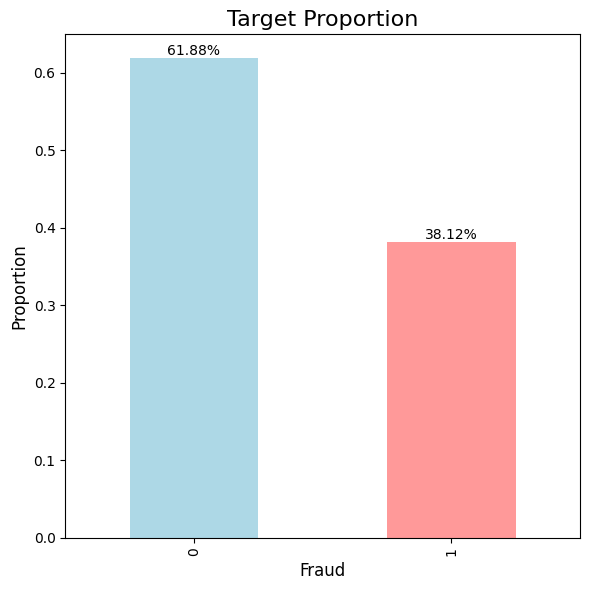

In [14]:
target_dist = df['PotentialFraud'].value_counts(normalize=True)
    
# Plot the bar chart
plt.figure(figsize=(6, 6))
target_dist.plot(kind='bar', color=['#ADD8E6', '#FF9999'])

# Adding titles and labels
title = 'Target Proportion'
plt.title(title, fontsize=16)
plt.xlabel('Fraud', fontsize=12)
plt.ylabel('Proportion', fontsize=12)

# Adding percentage labels on top of bars
for index, value in enumerate(target_dist):
    plt.text(index, value, f'{value:.2%}', ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()

### Outlier Check

In [15]:
def count_outliers_per_column(data, threshold=1.5):
    """
    Function to find the count of outliers for each numeric column in the DataFrame based on the IQR method.
    
    Parameters:
    data (pd.DataFrame): The input DataFrame
    threshold (float): The threshold multiplier for the IQR (default is 1.5)
    
    Returns:
    dict: A dictionary where the keys are column names and the values are the count of outliers in that column.
    """
    outlier_counts = {}
    
    # Loop through each numeric column in the DataFrame
    for col in data.select_dtypes(include=['float64', 'int64']):
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define the bounds for detecting outliers
        lower_bound = Q1 - (threshold * IQR)
        upper_bound = Q3 + (threshold * IQR)
        
        # Find the number of outliers
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        outlier_count = outliers.shape[0]
        
        if outlier_count > 0:
            outlier_counts[col] = outlier_count
    
    return outlier_counts

In [16]:
count_outliers_per_column(df)

{'InscClaimAmtReimbursed': 94652,
 'DeductibleAmtPaid': 61510,
 'ClaimPeriod': 104258,
 'TimeInHptal': 39869,
 'Diagnosis Count': 41815,
 'Procedures Count': 23310,
 'SamePhysician': 62658,
 'OPD_Flag': 40474,
 'RenalDiseaseIndicator': 109848,
 'NoOfMonths_PartACov': 3489,
 'NoOfMonths_PartBCov': 4293,
 'IPAnnualReimbursementAmt': 63042,
 'IPAnnualDeductibleAmt': 21320,
 'OPAnnualReimbursementAmt': 37797,
 'OPAnnualDeductibleAmt': 35506,
 'Age': 24233,
 'ChronicDisease_Count': 462}

In [17]:
num_cols = df.select_dtypes(include='number').columns
num_cols

Index(['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'ClaimPeriod',
       'TimeInHptal', 'Diagnosis Count', 'Procedures Count', 'SamePhysician',
       'OPD_Flag', 'PotentialFraud', 'RenalDiseaseIndicator', 'County',
       'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age',
       'ChronicDisease_Count'],
      dtype='object')

In [18]:
def plot_boxplots_for_numerical_columns(df):
    """
    Plots boxplots for all numerical columns in the given DataFrame to check for outliers.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    """
    # Selecting only numerical columns from the DataFrame
    numerical_columns = df.select_dtypes(include=['number']).columns
    
    # Setting up the size of the plot
    plt.figure(figsize=(15, len(numerical_columns) * 4))
    
    # Loop through each numerical column and create a boxplot
    for i, column in enumerate(numerical_columns, 1):
        plt.subplot(len(numerical_columns), 1, i)
        sns.boxplot(x=df[column])
        plt.title(f'Boxplot of {column}')
    
    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

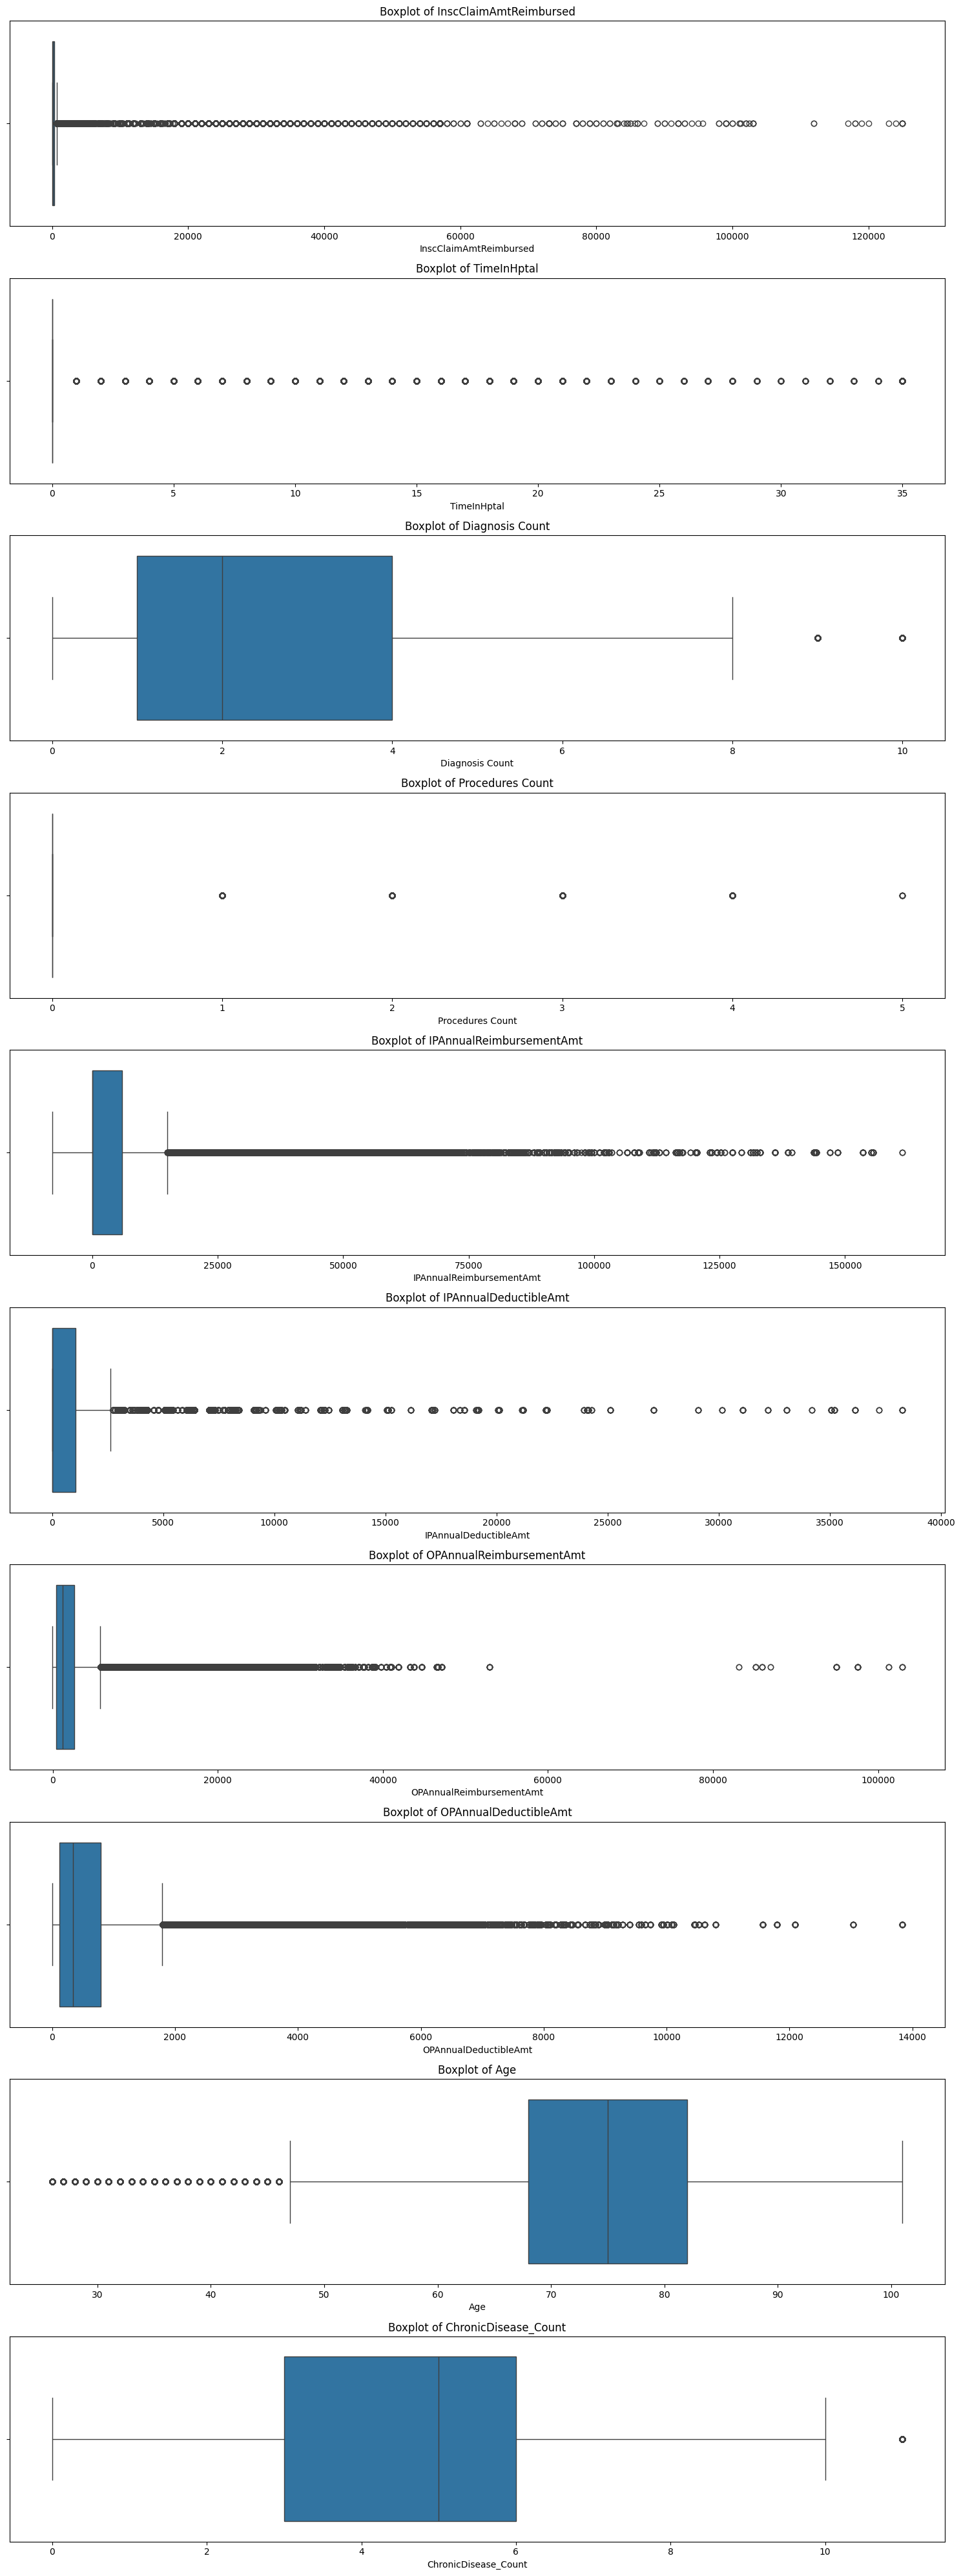

In [19]:
plot_boxplots_for_numerical_columns(df[['InscClaimAmtReimbursed',
       'TimeInHptal', 'Diagnosis Count', 'Procedures Count', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age', 'ChronicDisease_Count']])

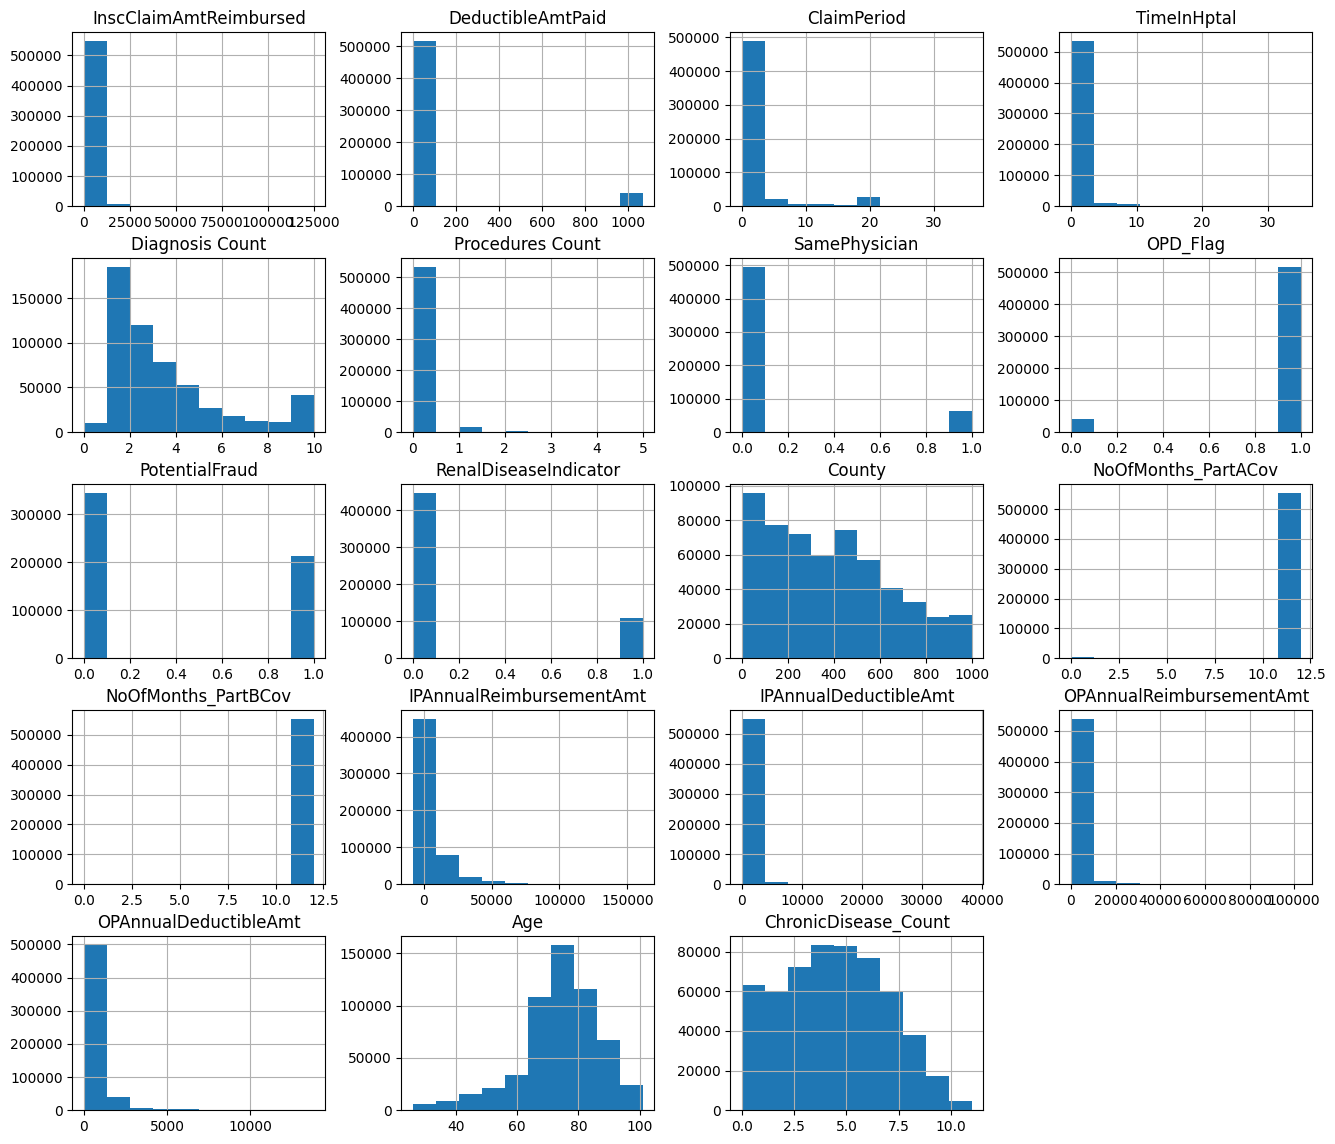

In [20]:
# Plotting histograms for numerical features
df[num_cols].hist(figsize=(16, 14))
plt.show()

In [21]:
num_cols

Index(['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'ClaimPeriod',
       'TimeInHptal', 'Diagnosis Count', 'Procedures Count', 'SamePhysician',
       'OPD_Flag', 'PotentialFraud', 'RenalDiseaseIndicator', 'County',
       'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age',
       'ChronicDisease_Count'],
      dtype='object')

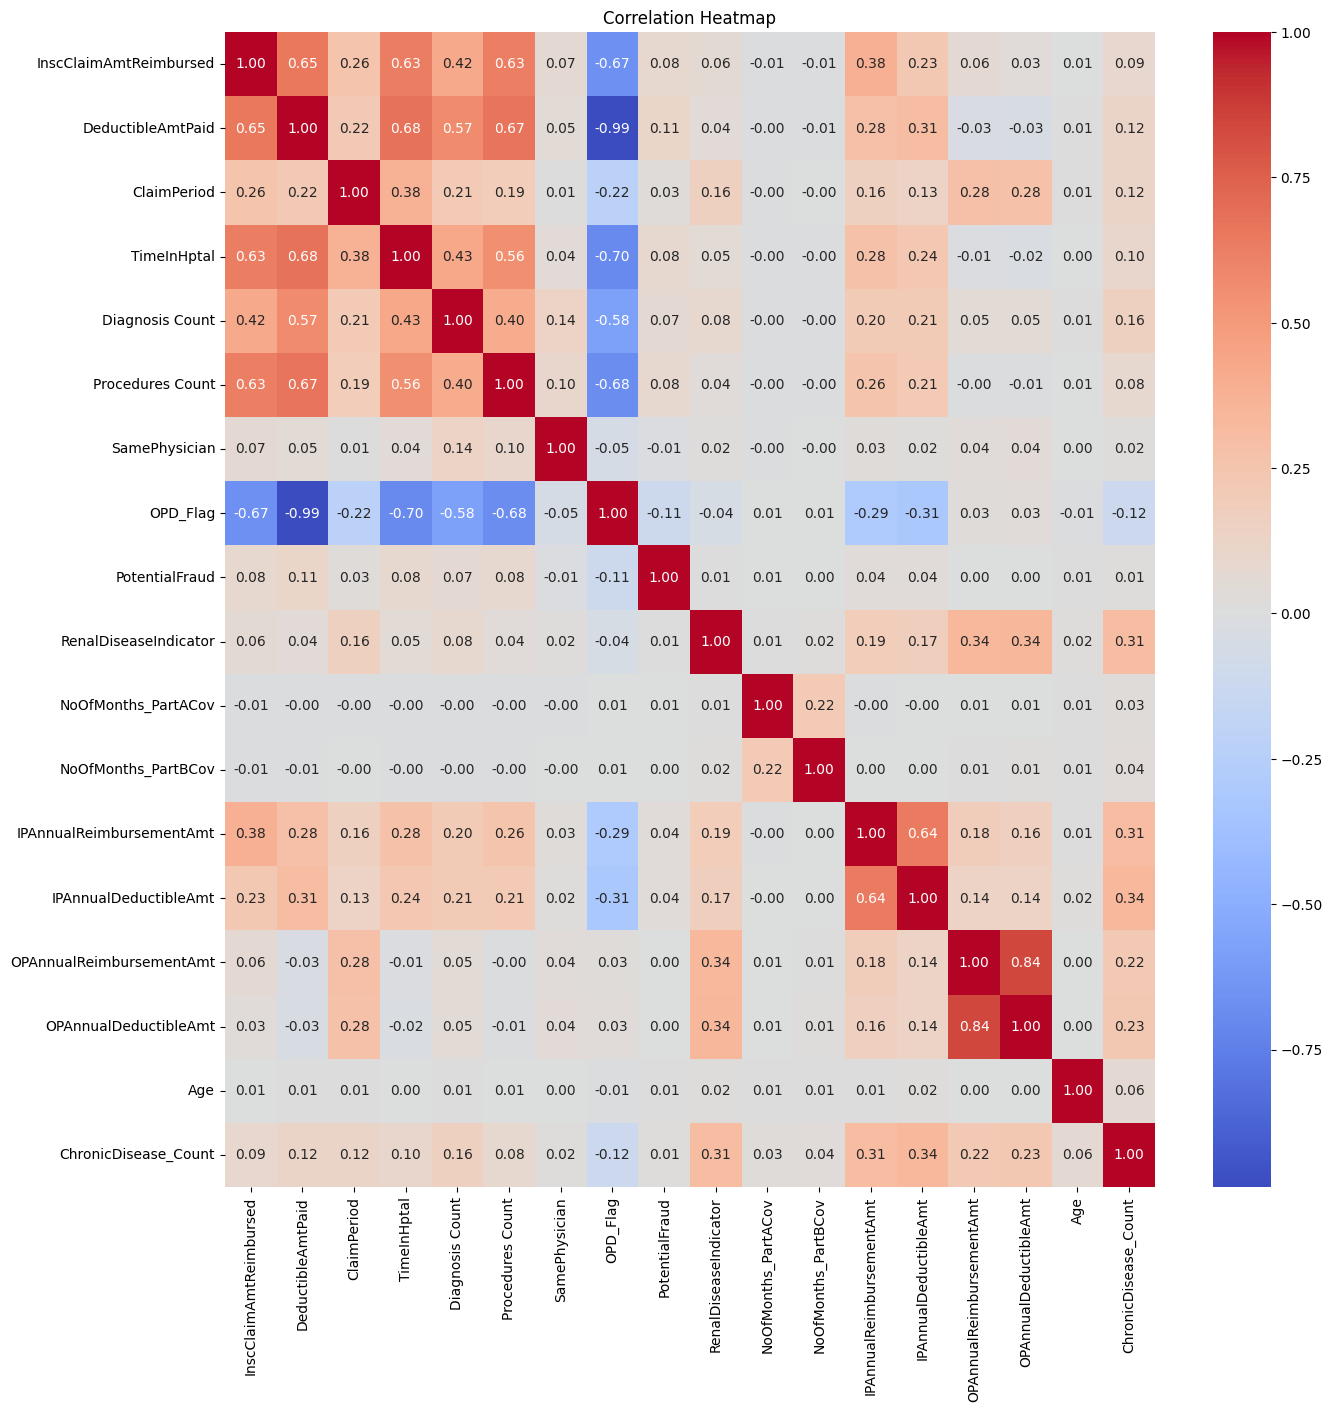

In [24]:
# Selecting only numeric columns for correlation matrix
cor_num_cols = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'ClaimPeriod',
       'TimeInHptal', 'Diagnosis Count', 'Procedures Count', 'SamePhysician',
       'OPD_Flag', 'PotentialFraud', 'RenalDiseaseIndicator',
       'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age',
       'ChronicDisease_Count']
# Plotting the heatmap for numerical data correlation
plt.figure(figsize=(15, 15))
sns.heatmap(df[cor_num_cols].corr(), annot=True,fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

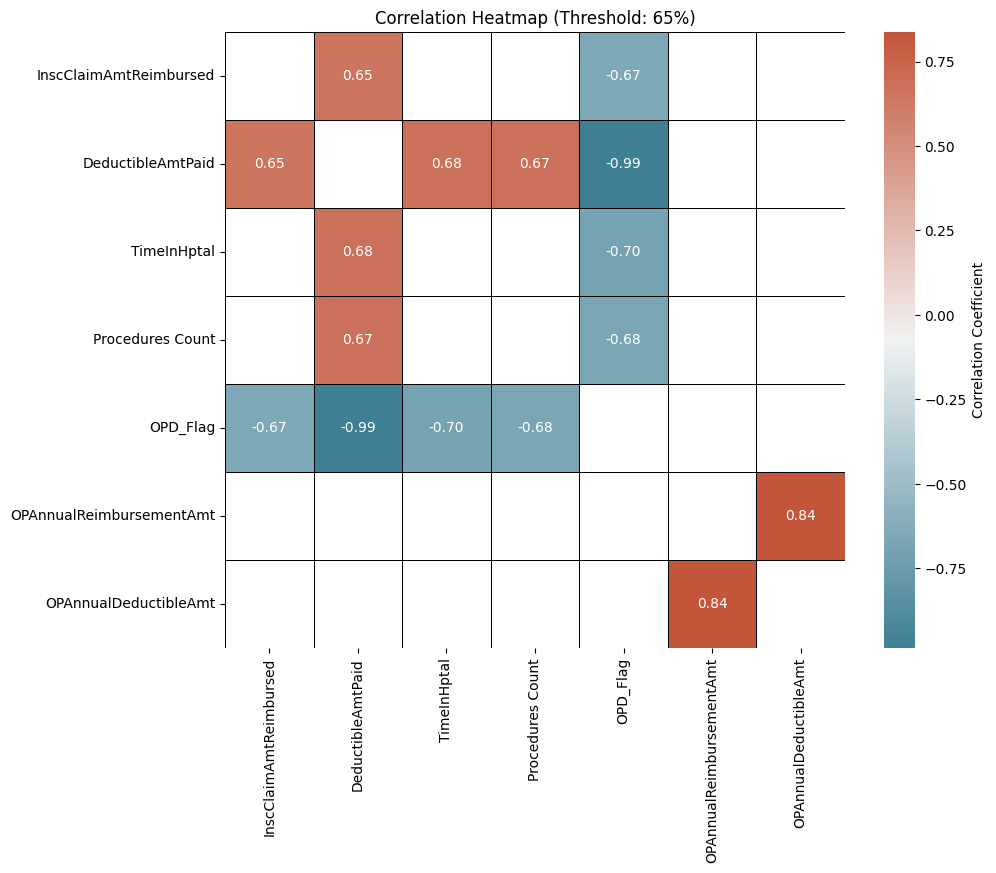

In [64]:
# Calculate the correlation matrix
corr_matrix = df[cor_num_cols].corr()

# Set the threshold for strong correlations (e.g., 60% or 0.6)
threshold = 0.65

# Filter the correlation matrix to keep only correlations above the threshold (absolute value)
filtered_corr = corr_matrix[(corr_matrix.abs() >= threshold) & (corr_matrix != 1)]

# Drop rows and columns where all values are NaN (i.e., no correlation above threshold)
filtered_corr = filtered_corr.dropna(how='all').dropna(axis=1, how='all')

# Create a more distinct colormap (e.g., "Spectral" for wide variation in color)
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Plot the filtered heatmap with color changes and borders
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr, annot=True, fmt=".2f", cmap=cmap, linewidths=0.5, linecolor='black', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap (Threshold: 65%)')
plt.show()

In [48]:
def plot_bivariate_analysis(df, column_name, target_column, title, x_label=None, y_label=None):
    """
    Plots a side-by-side bar chart for bivariate analysis between a feature and a target variable.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The column name for the feature to analyze.
    target_column (str): The target column to compare against.
    title (str): The title of the plot.
    x_label (str, optional): The label for the x-axis (defaults to column_name).
    y_label (str, optional): The label for the y-axis (defaults to 'No. of Patients').
    """
    
    # Creating a crosstab between the feature and the target column (raw counts for y-axis)
    crosstab = pd.crosstab(df[column_name], df[target_column])
    
    # Calculating percentages for labeling
    crosstab_percentage = pd.crosstab(df[column_name], df[target_column], normalize='index') * 100
    
    # Sorting the crosstab by total records in descending order
    crosstab['Total'] = crosstab.sum(axis=1)
    crosstab = crosstab.sort_values(by='Total', ascending=False)
    crosstab = crosstab.drop(columns='Total')  
    
    # Bar width and positions for side-by-side bars
    bar_width = 0.35
    indices = np.arange(len(crosstab))  # Position of bars on x-axis
    
    # Creating the bar plot
    plt.figure(figsize=(10, 6))
    
    # Plot the bars side by side for each category ('Yes' and 'No')
    plt.bar(indices, crosstab.iloc[:, 0], bar_width, label=crosstab.columns[0], color='#ADD8E6')  # First column ('No')
    plt.bar(indices + bar_width, crosstab.iloc[:, 1], bar_width, label=crosstab.columns[1], color='#FF9999')  # Second column ('Yes')
    
    # Set x-tick positions and labels
    plt.xticks(indices + bar_width / 2, crosstab.index, rotation=45)
    
    # Set titles and labels
    plt.title(title, fontsize=16)
    plt.xlabel(x_label if x_label else column_name, fontsize=12)
    plt.ylabel(y_label if y_label else 'No. of Patients', fontsize=12)
    
    # Adding percentage labels above the bars (rounded to 2 digits)
    for i in range(len(crosstab)):
        plt.text(i, crosstab.iloc[i, 0] + 1, f'{crosstab_percentage.iloc[i, 0]:.2f}%', ha='center', va='bottom')
        plt.text(i + bar_width, crosstab.iloc[i, 1] + 1, f'{crosstab_percentage.iloc[i, 1]:.2f}%', ha='center', va='bottom')
    
    # Adding legend on the right side of the plot
    plt.legend(title=target_column, loc='upper right')
    
    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

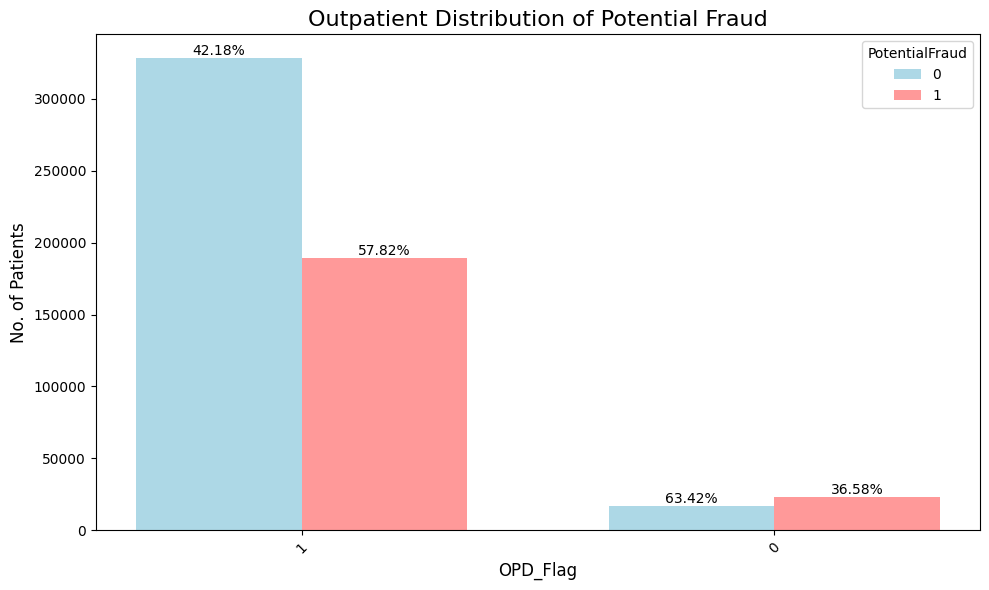

In [49]:
plot_bivariate_analysis(df, 'OPD_Flag', 'PotentialFraud', 'Outpatient Distribution of Potential Fraud')

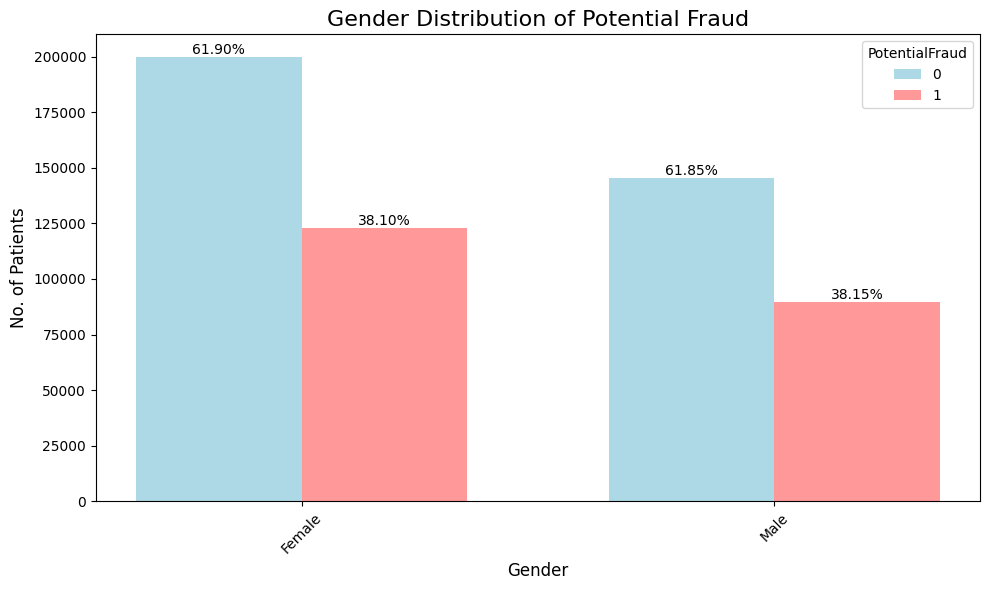

In [50]:
plot_bivariate_analysis(df, 'Gender', 'PotentialFraud', 'Gender Distribution of Potential Fraud')

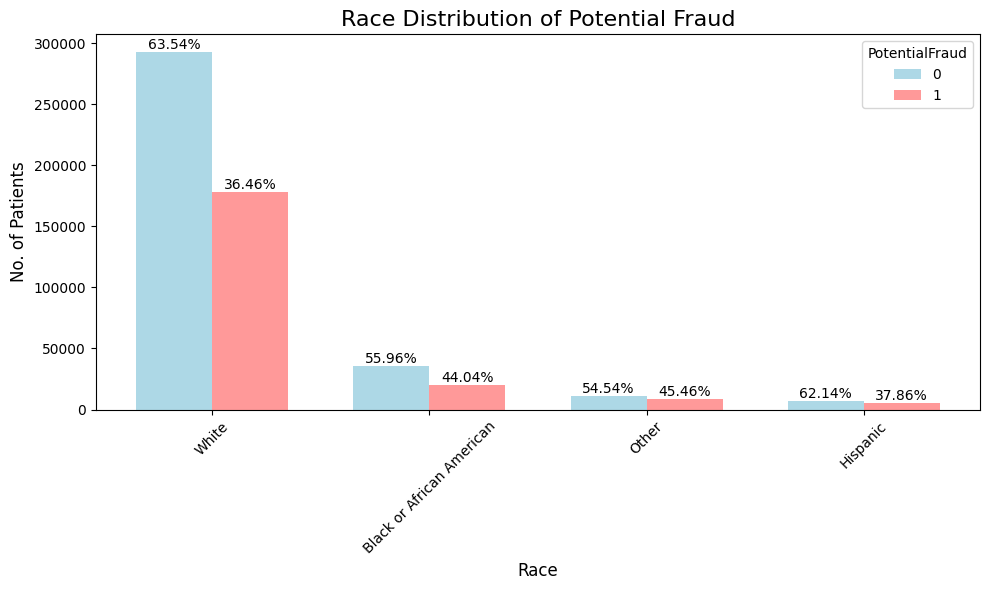

In [51]:
plot_bivariate_analysis(df, 'Race', 'PotentialFraud', 'Race Distribution of Potential Fraud')

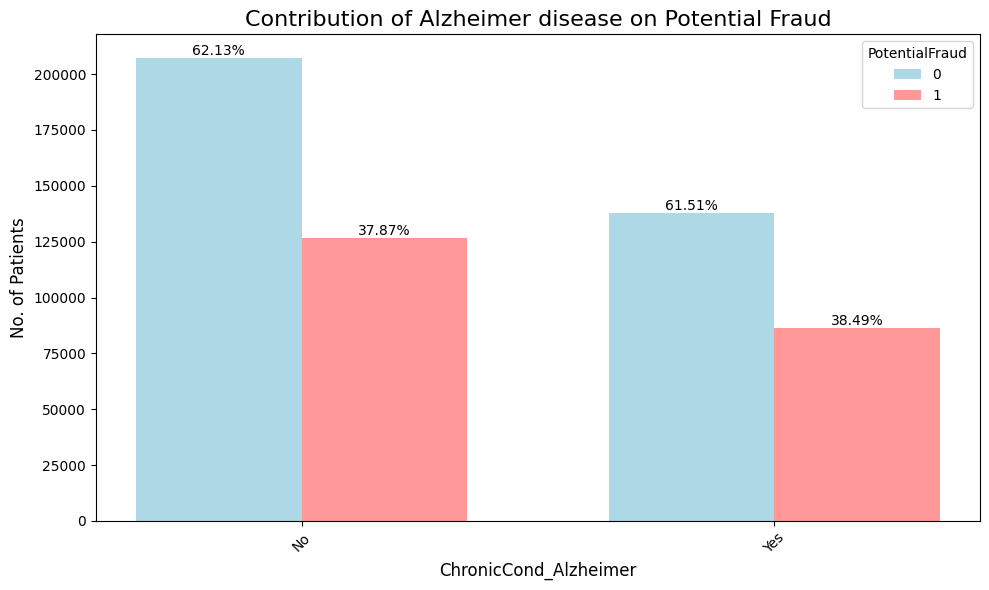

In [52]:
plot_bivariate_analysis(df, 'ChronicCond_Alzheimer', 'PotentialFraud', 'Contribution of Alzheimer disease on Potential Fraud')

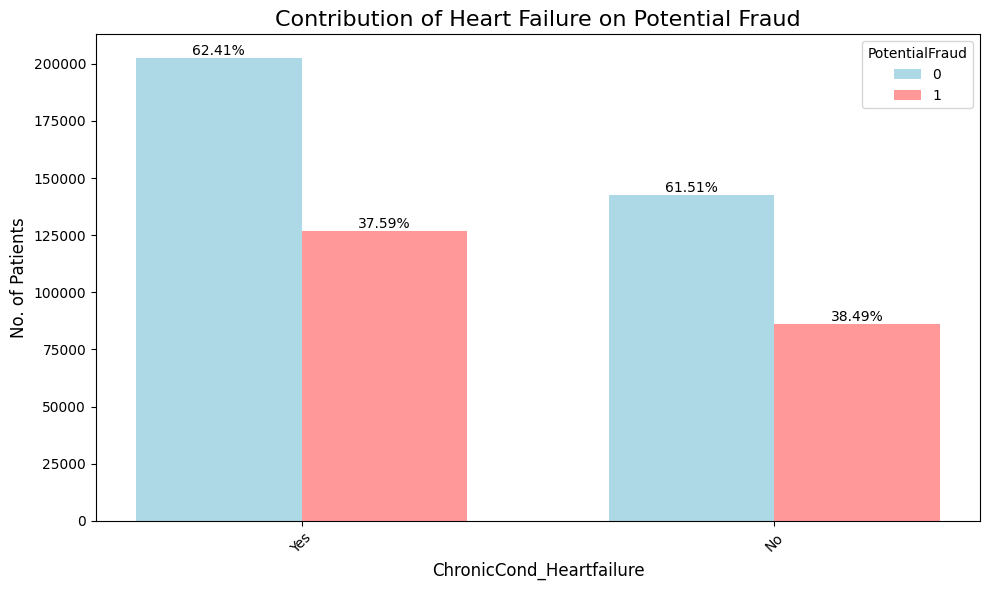

In [53]:
plot_bivariate_analysis(df, 'ChronicCond_Heartfailure', 'PotentialFraud', 'Contribution of Heart Failure on Potential Fraud')

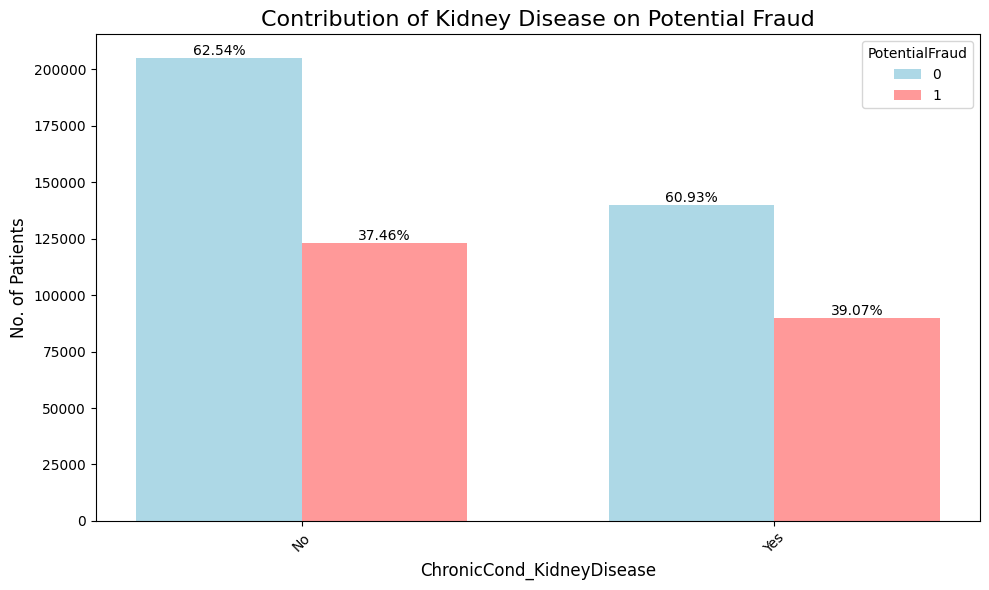

In [54]:
plot_bivariate_analysis(df, 'ChronicCond_KidneyDisease', 'PotentialFraud', 'Contribution of Kidney Disease on Potential Fraud')

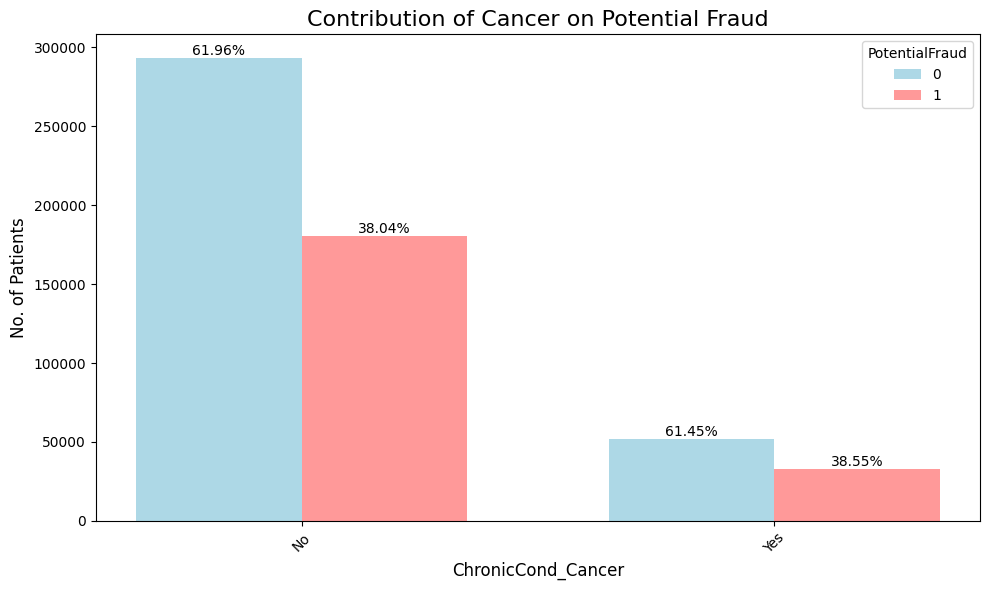

In [55]:
plot_bivariate_analysis(df, 'ChronicCond_Cancer', 'PotentialFraud', 'Contribution of Cancer on Potential Fraud')

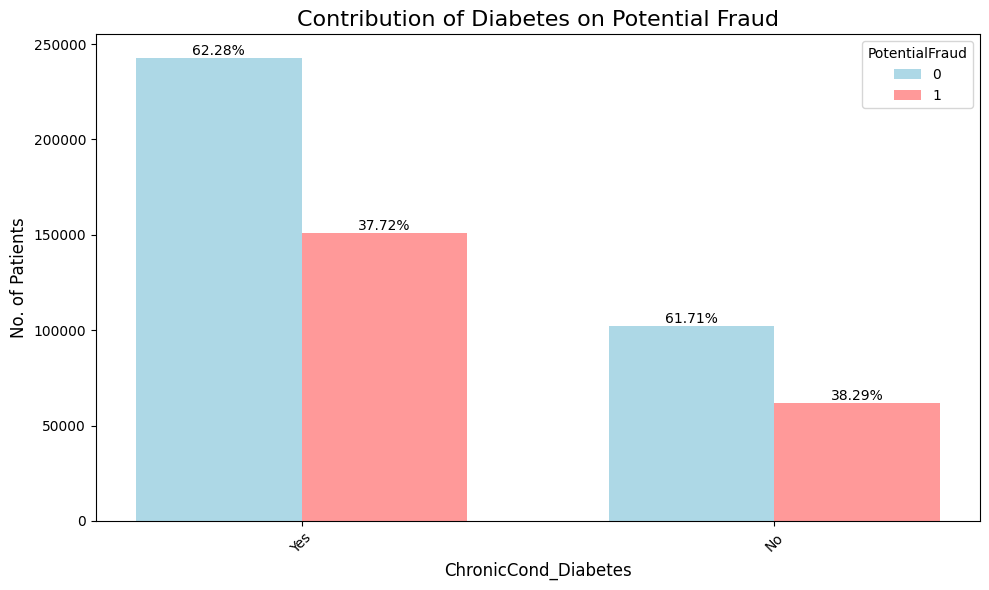

In [56]:
plot_bivariate_analysis(df, 'ChronicCond_Diabetes', 'PotentialFraud', 'Contribution of Diabetes on Potential Fraud')

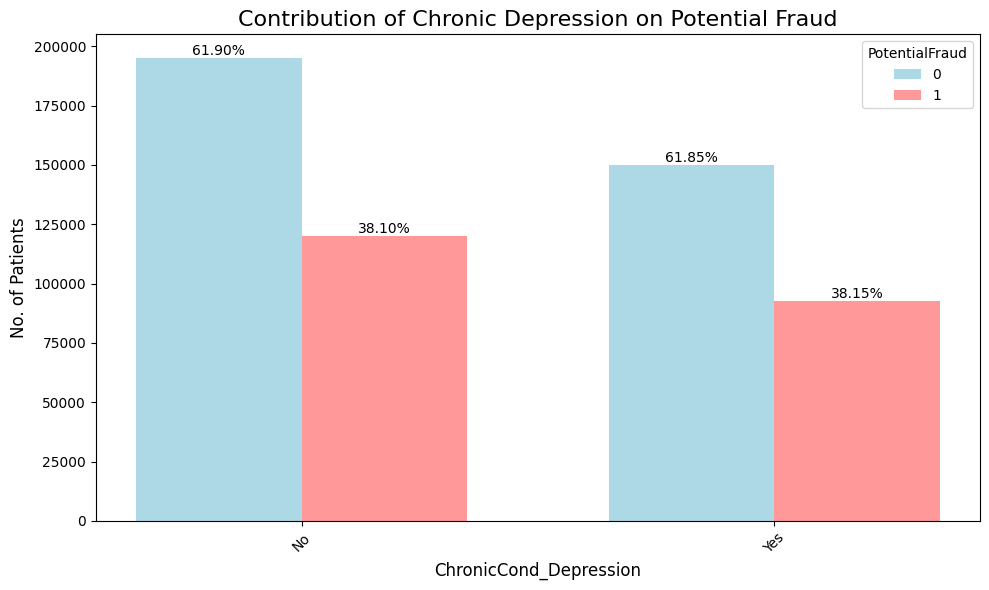

In [57]:
plot_bivariate_analysis(df, 'ChronicCond_Depression', 'PotentialFraud', 'Contribution of Chronic Depression on Potential Fraud')

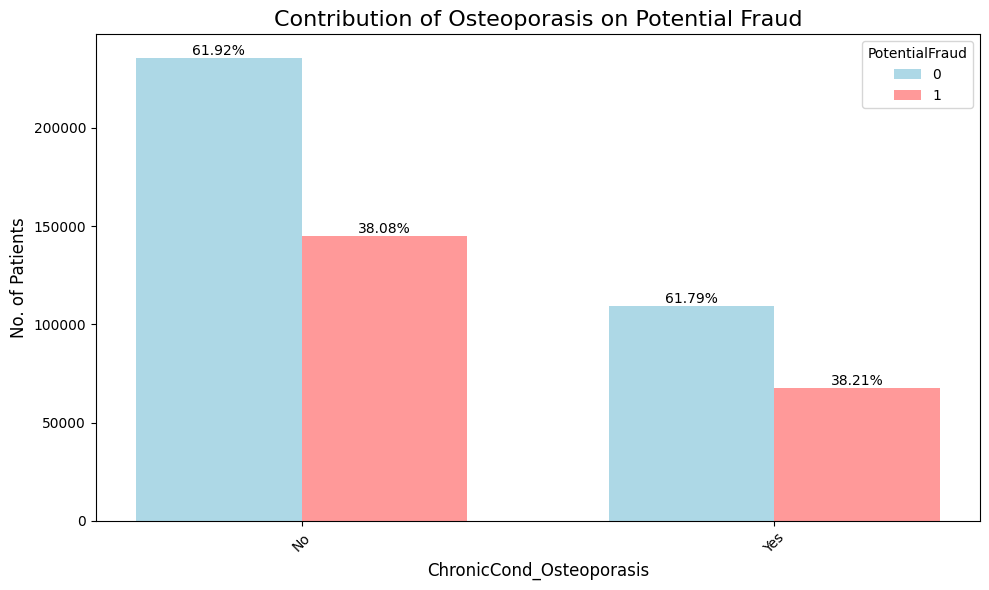

In [65]:
plot_bivariate_analysis(df, 'ChronicCond_Osteoporasis', 'PotentialFraud', 'Contribution of Osteoporasis on Potential Fraud')

In [26]:
df.columns

Index(['BeneID', 'ClaimID', 'Provider', 'InscClaimAmtReimbursed',
       'DeductibleAmtPaid', 'ClaimPeriod', 'TimeInHptal', 'Diagnosis Count',
       'Procedures Count', 'SamePhysician', 'OPD_Flag', 'PotentialFraud',
       'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State',
       'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt', 'Age', 'ChronicDisease_Count'],
      dtype='object')

In [97]:
def univariate_analysis(df, column_name):
    """
    Plots a histogram for a single numeric column to show its distribution.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The numeric column to analyze.
    
    Returns:
    None: Displays the histogram.
    """
    
    # Check if the column is numeric or categorical
    if df[column_name].dtype in ['int64', 'float64']:
        # For numeric data, plot a histogram with KDE
        plt.figure(figsize=(10, 6))
        sns.histplot(df[column_name], bins=30, color='blue', alpha=0.6,stat='count', kde=False)
        sns.kdeplot(df[column_name], color='orange', linewidth=2)
        plt.title(f'Histogram of {column_name} with Distribution Curve', fontsize=16)
        plt.xlabel(column_name, fontsize=12)
        plt.ylabel('Number of Patients', fontsize=12)
    else:
        # For categorical data, plot a bar chart
        plt.figure(figsize=(10, 6))
        sns.countplot(x=df[column_name], color='blue', alpha=0.6)
        plt.title(f'Distribution of {column_name}', fontsize=16)
        plt.xlabel(column_name, fontsize=12)
        plt.ylabel('No. of Patients', fontsize=12)

    plt.tight_layout()
    plt.show()

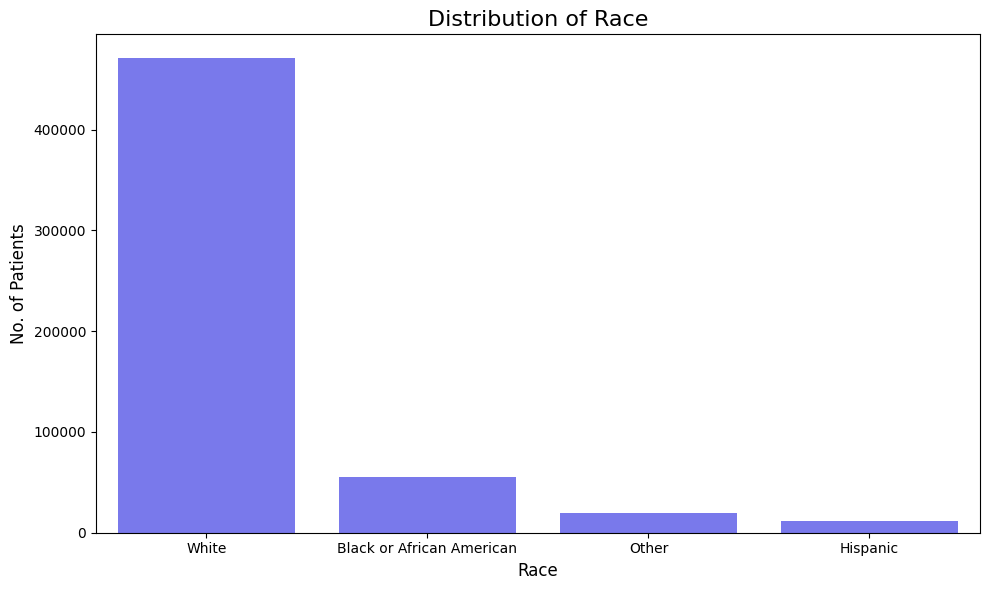

In [98]:
univariate_analysis(df, 'Race')

In [99]:
df['Age'].dtypes

dtype('float64')

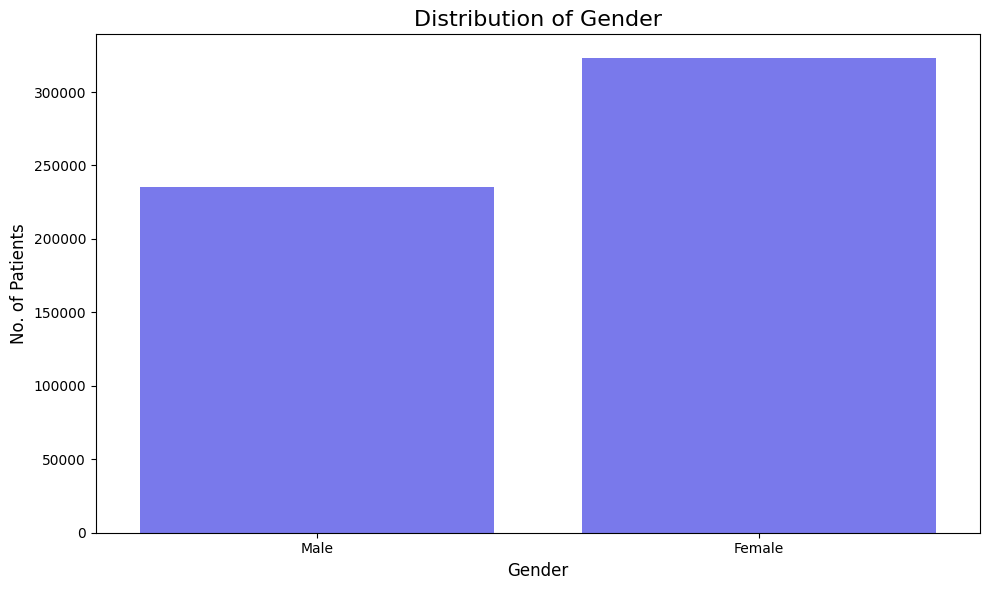

In [102]:
univariate_analysis(df, 'Gender')

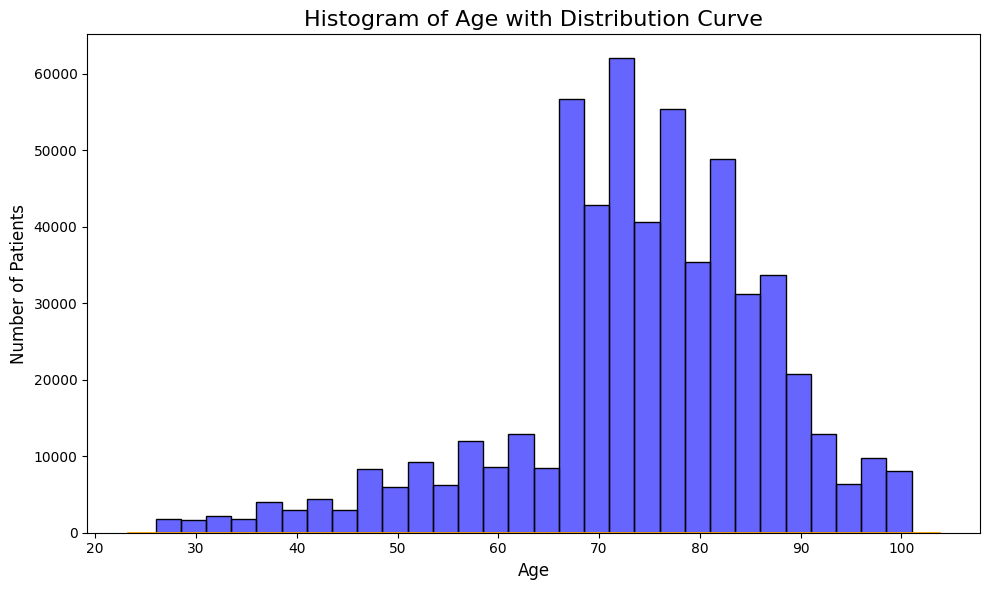

In [100]:
univariate_analysis(df, 'Age')

### Hypothesis Testing (Numerical Variable)

#### Claim Amount Reimbursed

Null Hypothesis (H0): There is no difference in the average InscClaimAmtReimbursed between fraud and non-fraud cases.

Alternative Hypothesis (H1): There is a difference in the average InscClaimAmtReimbursed between fraud and non-fraud cases.

In [106]:
def t_test_continuous_variable(df, continuous_variable):
    fraud = df[df['PotentialFraud'] == 1][continuous_variable]
    non_fraud = df[df['PotentialFraud'] == 0][continuous_variable]
    
    t_stat, p_value = stats.ttest_ind(fraud, non_fraud, equal_var=False)
    return t_stat, p_value

In [107]:
# InscClaimAmtReimbursed
t_stat_claim, p_value_claim = t_test_continuous_variable(df, 'InscClaimAmtReimbursed')
print(f"T-test for InscClaimAmtReimbursed: t-statistic={t_stat_claim}, p-value={p_value_claim}")


T-test for InscClaimAmtReimbursed: t-statistic=54.66285431110228, p-value=0.0


A T-test was conducted to evaluate whether there is a significant difference in the insurance claim amounts reimbursed (InscClaimAmtReimbursed) between fraudulent and non-fraudulent claims. The results of the T-test are as follows:

T-statistic: 54.66
P-value: 0.00

Given that the P-value is well below the conventional significance level of 0.05, we reject the null hypothesis. 
This result indicates a statistically significant difference in the mean InscClaimAmtReimbursed between fraudulent and non-fraudulent claims.

### Time in Hospital

H0: There is no difference in the average TimeInHptal between fraud and non-fraud cases.

H1: There is a difference in the average TimeInHptal between fraud and non-fraud cases.

In [109]:
# TimeInHptal
t_stat_TimeInHptal, p_value_TimeInHptal= t_test_continuous_variable(df, 'TimeInHptal')
print(f"T-test for Time In Hospital: t-statistic={t_stat_TimeInHptal}, p-value={p_value_TimeInHptal}")

T-test for Time In Hospital: t-statistic=55.635716597235586, p-value=0.0


The T-statistic of 55.64 indicates a highly significant difference in the average time spent in the hospital between the two groups. The P-value of 0.00 suggests that the likelihood of observing such a large difference due to random sampling variation is essentially zero.
Since the P-value is significantly lower than the conventional threshold of 0.05, we reject the null hypothesis. This indicates a statistically significant difference in the mean Time in Hospital for fraudulent claims compared to non-fraudulent claims.

#### Age

H0: There is no difference in the average Age between fraud and non-fraud cases.

H1: There is a difference in the average Age between fraud and non-fraud cases.

In [110]:
# TimeInHptal
t_stat_age, p_value_age= t_test_continuous_variable(df, 'Age')
print(f"T-test for Time In Hospital: t-statistic={t_stat_age}, p-value={p_value_age}")

T-test for Time In Hospital: t-statistic=6.048881452046946, p-value=1.4596908709949243e-09


The T-statistic of 6.05 indicates a significant difference in the average time spent in the hospital between the two groups. The P-value of approximately 1.46 x 10^-9 suggests that the probability of observing such a large difference purely by chance is extremely low.

Given that the P-value is far below the conventional significance level of 0.05, we reject the null hypothesis. This indicates that there is a statistically significant difference in the mean Time in Hospital for fraudulent claims compared to non-fraudulent claims.

### Hypothesis Testing (Categorical Variable)

#### Gender
H0: There is no association between Gender and PotentialFraud.

H1: There is an association between Gender and PotentialFraud.

In [111]:
def chi_square_test(df, categorical_variable):
    contingency_table = pd.crosstab(df[categorical_variable], df['PotentialFraud'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p

# Example for Gender
chi2_gender, p_gender = chi_square_test(df, 'Gender')
print(f"Chi-square test for Gender: chi2={chi2_gender}, p-value={p_gender}")


Chi-square test for Gender: chi2=0.11595739146858941, p-value=0.7334610711386262


The Chi-square statistic of 0.116 indicates that there is a very weak association between gender and the occurrence of fraudulent claims. The P-value of 0.733 is significantly higher than the conventional significance level of 0.05, suggesting that we fail to reject the null hypothesis.

This implies that there is no statistically significant difference in the distribution of gender between fraudulent and non-fraudulent claims. In other words, gender does not appear to be a determining factor in identifying potentially fraudulent claims in this dataset.